### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ same-colored burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [232]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import ultranest

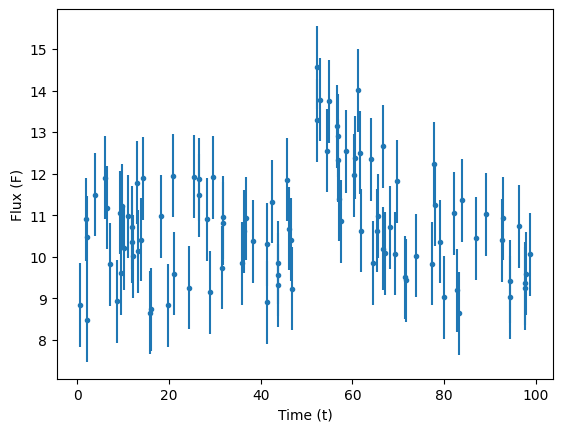

In [249]:
#Part 1 Read in data
data = np.load('../../../homeworks/hw_data/hw5_data_1.npy')

t_arr= data[:,0]
y_arr = data[:,1]
y_err_arr= data[:,2]
plt.errorbar(data[:,0], data[:,1], data[:,2], fmt=".")
plt.xlabel("Time (t)")
plt.ylabel("Flux (F)");

In [234]:
#Part 2

#Write burst model
def burst_model(theta, t_arr):
    b, A, t_0, alpha = theta
    t_fit= []
    for t in t_arr:
        if t < t_0:
            t_fit.append(b)
        else:
            t_fit.append(b + A* np.exp(-alpha* (t-t_0)))
    return t_fit
        

#Likelihood Function
def logL(theta, data=[t_arr, y_arr, y_err_arr], model=burst_model):
    """Gaussian log-likelihood of the model at b, A, t_0, alpha"""
    t, y, y_err = data
    y_fit = model(theta, t)
    return sum(stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, y_err))


In [235]:
#Part 3
def logPrior(x):
    # create a uniform prior in b, A, and t_0 and a log uniform prior in alpha
    prior_b = stats.uniform.pdf(x[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(x[1], loc=0, scale=50)
    prior_t_0 = stats.uniform.pdf(x[2], loc=0, scale=100)
    prior_ln_alpha = stats.uniform.pdf(np.log(x[3]), loc=-5, scale=10)
    return  np.log(prior_b * prior_A * prior_t_0 * prior_ln_alpha)

ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)

# intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False)

# sampler for N steps
N = int(1e5)
params = np.array([10.0, 5.0, 50.0, 0])
sampler.sample(params, N, SCAMweight=30, AMweight=15, DEweight=50)




Finished 0.00 percent in 0.000832 s Acceptance rate = 0

/tmp/ipykernel_59395/1089870667.py:7: RuntimeWarning: divide by zero encountered in log
  prior_ln_alpha = stats.uniform.pdf(np.log(x[3]), loc=-5, scale=10)
/tmp/ipykernel_59395/1089870667.py:8: RuntimeWarning: divide by zero encountered in log
  return  np.log(prior_b * prior_A * prior_t_0 * prior_ln_alpha)
/tmp/ipykernel_59395/1089870667.py:7: RuntimeWarning: invalid value encountered in log
  prior_ln_alpha = stats.uniform.pdf(np.log(x[3]), loc=-5, scale=10)


Finished 10.00 percent in 42.206074 s Acceptance rate = 0.51778Adding DE jump with weight 50
Finished 100.00 percent in 413.109301 s Acceptance rate = 0.45466
Run Complete


Taking every n = 8 samples based on ac length.
Burning first n = 500 samples.


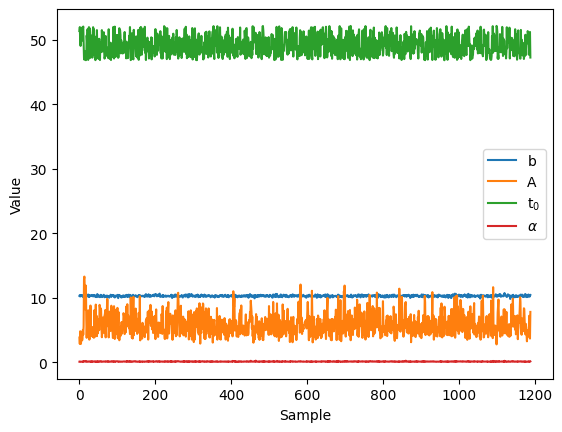

In [251]:
#Part 4
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

import acor
thin_arr=[]
for i in range(ndim): #find largest auto-correlation length out of all the parameters
    thin_arr.append(int(acor.acor(chain[:,i])[0]))
thin= np.max(thin_arr)
print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(500) + ' samples.')

b_chain= chain[500::thin,0]
A_chain= chain[500::thin,1]
t_0_chain= chain[500::thin,2]
alpha_chain = chain[500::thin,3]

plt.plot(b_chain, label="b");
plt.plot(A_chain, label="A");
plt.plot(t_0_chain, label=r"t$_0$");
plt.plot(alpha_chain, label=r"$\alpha$");
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()

(1188, 4)


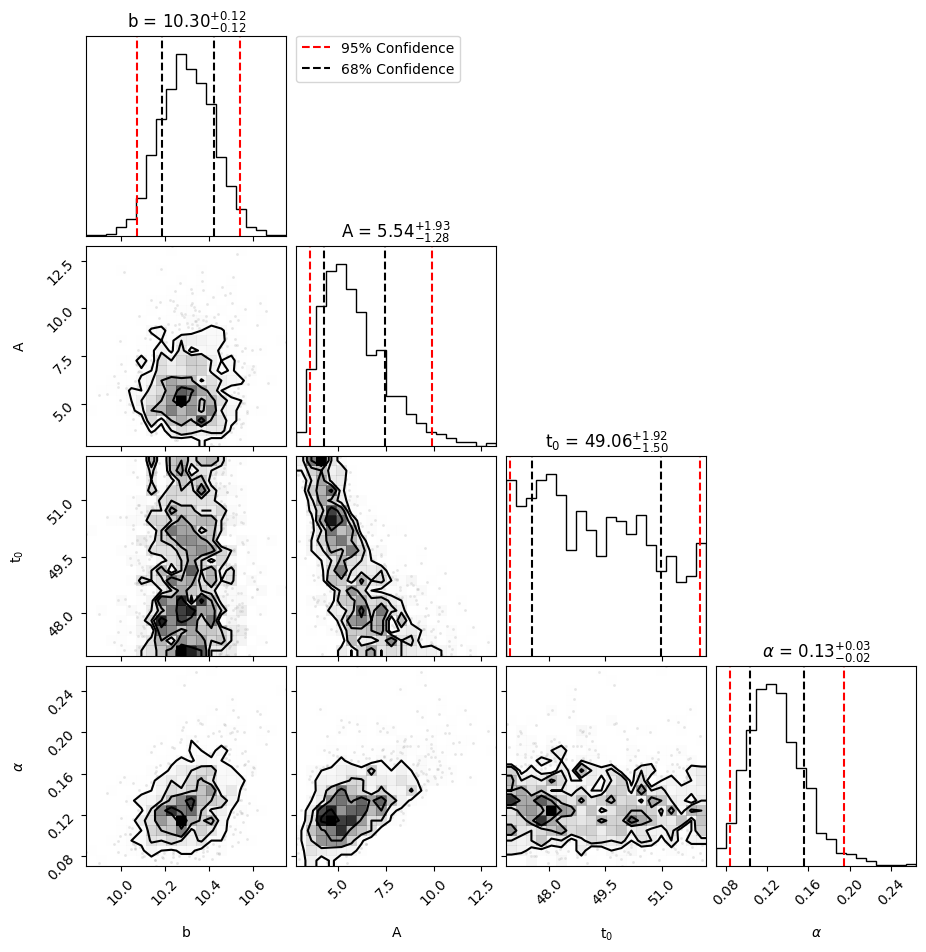

In [240]:
#Part 5
samples= chain[500::thin, 0:4]
print(np.shape(samples))

fig= corner.corner(samples,
    labels=["b", "A", r"t$_0$", r"$\alpha$"],  
    show_titles=True,
    title_kwargs={"fontsize": 12},  
    hist_kwargs={"density": True},  # Ensure histograms are normalized
    plot_density=True
)

axes = np.array(fig.axes).reshape((4, 4)) 

for i in range(4): 
    ax = axes[i, i]
    q_68 = np.percentile(samples[:, i], [16, 84])  # 68% CI
    q_95 = np.percentile(samples[:, i], [2.5, 97.5])  # Compute 95% 
    # Plot 95% CI in red dashed lines
    for j, q in enumerate(q_95):
        ax.axvline(q, color="red", linestyle="dashed", label="95% Confidence" if j == 0 else "")
    
    # Plot 68% CI in blue solid lines
    for j, q in enumerate(q_68):
        ax.axvline(q, color="black", linestyle="dashed", label="68% Confidence" if j == 0 else "")

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.show()


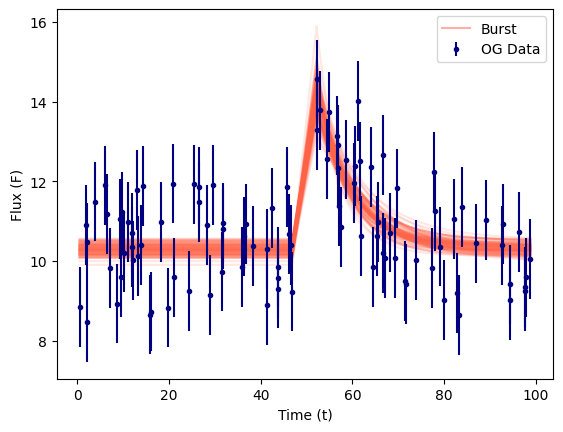

In [241]:
#Part 6
random_indices=np.random.randint(0,len(samples[:,0]), size=100)

for index in random_indices:
    theta_rand= chain[500::thin, 0:4][index]
    t_fit= burst_model(theta_rand, t_arr)
    if index == random_indices[0]:
        plt.plot(t_arr, t_fit, color="tomato", alpha=0.5, label="Burst")
    else:
        plt.plot(t_arr, t_fit, color="tomato", alpha=0.15)


plt.errorbar(data[:,0], data[:,1], data[:,2], fmt=".", color="navy", label="OG Data")
plt.xlabel("Time (t)")
plt.ylabel("Flux (F)")
plt.legend()
plt.show()

In [242]:
#Part 7
#Write gaussian model
def gaussian_model(theta, t_arr):
    b, A, t_0, sig_w = theta
    t_fit= []
    for t in t_arr:
        if t < t_0:
            t_fit.append(b)
        else:
            t_fit.append(b + A* np.exp( ((t-t_0)**2)/(2*sig_w**2)))
    return t_fit
        
def my_likelihood(params):
    b, A, t_0, sig_w = params
    # compute intensity at every x position according to the model
    y_model = b + A* np.exp( -((t_arr-t_0)**2)/(2*sig_w**2))
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - y_arr)/y_err_arr)**2).sum()
    return like

def gaussian_prior(tesseract):
    params =tesseract.copy()

    # uniform prior for b
    lo = 0
    hi = 50
    params[0] =tesseract[0] * (hi - lo) + lo

    #uniform prior for A
    lo = 0
    hi = 50
    params[1] =tesseract[1] * (hi - lo) + lo

    #uniform prior for t_0
    lo = 0
    hi = 100
    params[2] =tesseract[2] * (hi - lo) + lo

    #log-uniform prior for log(sig_w)
    lo = np.e**(-2)
    hi = np.e**2
    params[3] = np.e**(tesseract[3] * (np.log(hi) - np.log(lo)) + np.log(lo))

    return params


param_names = ["b", "A", r"t$_0$", r"$\sigma_w$"]

sampler_gaussian = ultranest.ReactiveNestedSampler(param_names, my_likelihood, 
                                          gaussian_prior)

In [243]:
result_gaussian = sampler_gaussian.run()
sampler_gaussian.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-52.5471..-52.5466]*| it/evals=8120/54196 eff=15.0941% N=400        0 
[ultranest] Likelihood function evaluations: 54198
[ultranest]   logZ = -68.15 +- 0.1729
[ultranest] Effective samples strategy satisfied (ESS = 2093.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.

logZ = -68.197 +- 0.474
  single instance: logZ = -68.197 +- 0.186
  bootstrapped   : logZ = -68.152 +- 0.474
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.81  │ ▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▇▆▇▇▇▆▆▅▃▃▃▁▂▁▁▁▁▁▁▁▁ │10.80     10.32 +- 0.12
    A                   : 1.32  │ ▁▁▁▁▁▁▂▂▃▆▆▇▇▇▆▆▄▃▃▂▁▁▁▁▁▁▁▁▁▁      ▁ │5.37      2.76 +- 0.37
    t$_0$               : 51.5

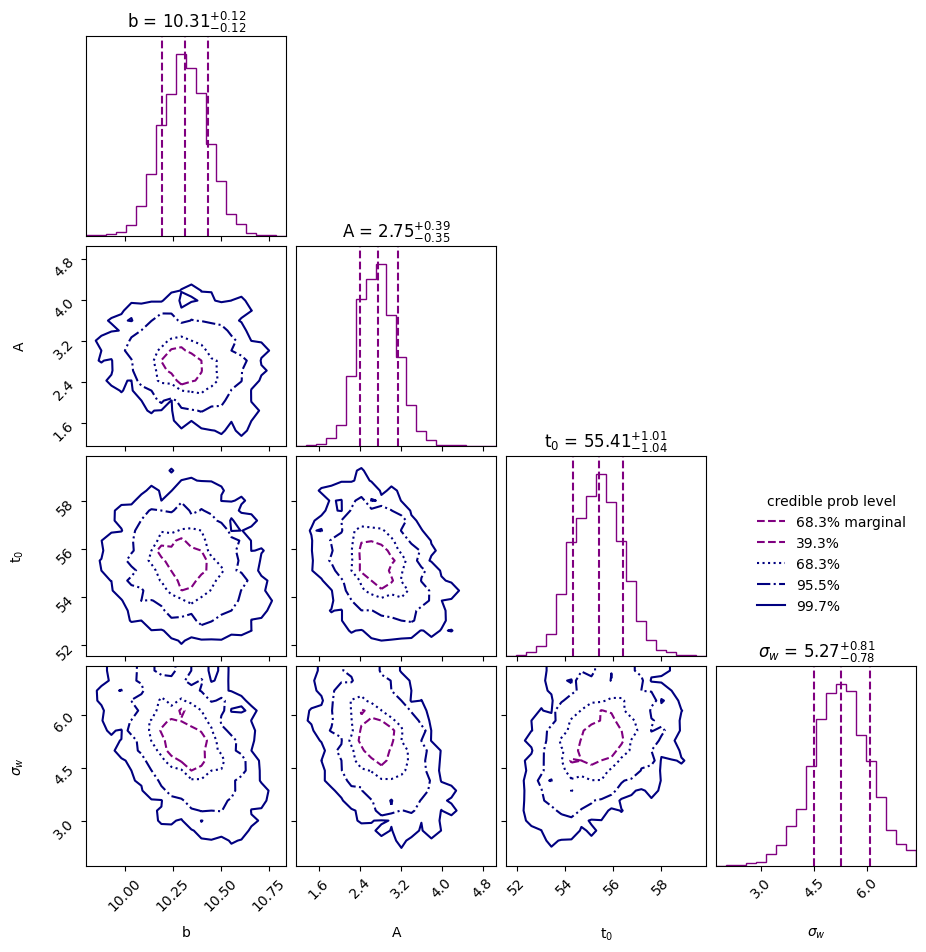

In [244]:
from ultranest.plot import cornerplot
cornerplot(result_gaussian);

In [245]:
#Now for burst model
def burst_likelihood(params):
    b, A, t_0, alpha = params
    # compute intensity at every x position according to the model
    y_model=[]
    for t in t_arr:
        if t < t_0:
            y_fit= b
        else:
            y_fit = b + A* np.exp(-alpha* (t-t_0))
        y_model.append(y_fit)
    # compare model and data with gaussian likelihood:
    like = -0.5 * (((y_model - y_arr)/y_err_arr)**2).sum()
    return like

def gaussian_prior(tesseract):
    params =tesseract.copy()

    # uniform prior for b
    lo = 0
    hi = 50
    params[0] =tesseract[0] * (hi - lo) + lo

    #uniform prior for A
    lo = 0
    hi = 50
    params[1] =tesseract[1] * (hi - lo) + lo

    #uniform prior for t_0
    lo = 0
    hi = 100
    params[2] =tesseract[2] * (hi - lo) + lo

    #log-uniform prior for alpha
    lo = np.e**(-5)
    hi = np.e**5
    params[3] = np.e**(tesseract[3] * (np.log(hi) - np.log(lo)) + np.log(lo))

    return params


param_names = ["b", "A", r"t$_0$", r"$\alpha$"]

sampler = ultranest.ReactiveNestedSampler(param_names, burst_likelihood, 
                                          gaussian_prior)

In [246]:
result = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+01   [-48.8123..-48.8122]*| it/evals=7760/85527 eff=9.1158% N=400    0 0  0 
[ultranest] Likelihood function evaluations: 85539
[ultranest]   logZ = -63.59 +- 0.1524
[ultranest] Effective samples strategy satisfied (ESS = 1874.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -63.589 +- 0.373
  single instance: logZ = -63.589 +- 0.182
  bootstrapped   : logZ = -63.595 +- 0.373
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.79  │ ▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▅▆▆▇▇▇▇▆▅▄▄▃▂▁▁▁▁▁▁▁▁▁ │10.78     10.30 +- 0.12
    A                   : 1.6   │ ▁▁▃▆▇▇▇▆▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁ ▁▁    ▁ │21.3      5.8 +- 1.7
    t$_0$               : 46.6  

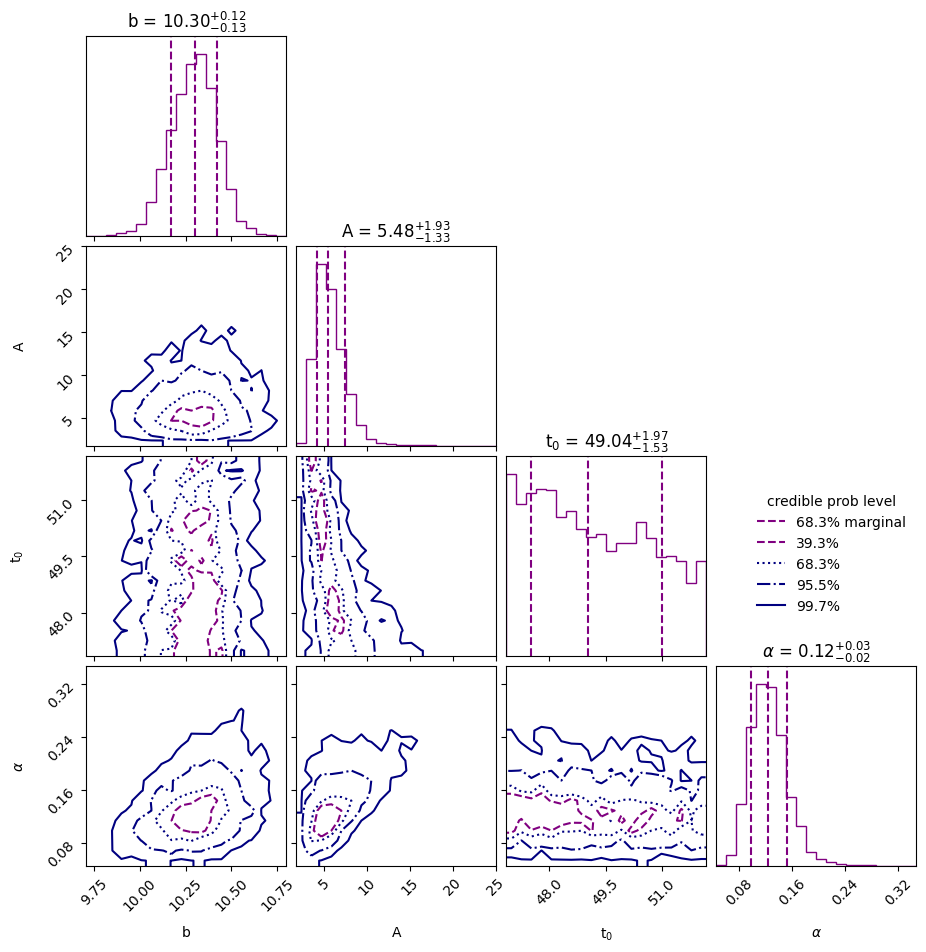

In [247]:
from ultranest.plot import cornerplot
cornerplot(result);

In [250]:
#Evidence for Burst Model
burst_evidence= np.e**result['logz']
print(f"Estimated evidence for burst: {burst_evidence}")
#Evidence for Gaussian
gaussian_evidence= np.e**result_gaussian['logz']
print(f"Estimated evidence for gaussian: {gaussian_evidence}")

#Bayes Factor
bfactor = burst_evidence/gaussian_evidence

if bfactor < 1: 
    print(f"The gaussian model is preferred with a Bayes Factor of {bfactor}")
else:
    print(f"The burst model is preferred with a Bayes Factor of {bfactor}")

Estimated evidence for burst: 2.4201142669433603e-28
Estimated evidence for gaussian: 2.411939672637263e-30
The burst model is preferred with a Bayes Factor of 100.33892200534017
